# カギ足の描画

出典1：plot a kagi chart using python not JavaScript or other code

https://stackoverfLow.com/questions/75027757/plot-a-kagi-chart-using-python-not-javascript-or-other-code

出典2：Matplotlib 時系列データの軸設定｜自由に時間軸を設定！

https://www.yutaka-note.com/entry/matplotlib_time_axis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.dates as mdates

## 株価データの取得

In [2]:
# Define the stock symbol and timeframe
symbol = '7203.T' # 7203はトヨタ自動車
end_date = datetime.today()
start_date = end_date - timedelta(days=180)  # 6 months before today
yf.pdr_override()
# yahooサイトからデータをダウンロード
stock_data = pdr.get_data_yahoo(symbol, start_date, end_date)
stock_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-09,2055.0,2057.5,2030.0,2051.5,2051.5,37276500
2023-06-12,2065.5,2073.5,2054.5,2069.0,2069.0,19714600
2023-06-13,2100.0,2183.0,2099.5,2173.5,2173.5,70125200
2023-06-14,2260.0,2350.0,2235.0,2310.0,2310.0,99612100
2023-06-15,2346.0,2358.0,2303.5,2320.5,2320.5,57885900


## カギ足のためのデータ準備の関数

In [3]:
def KagiChart(df,delta):
    # カギ足描画のためのデータフレームの初期化
    kagi_df = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Extreme', 'Direc'])

    # データの出発点における設定
    trend = 0
    kagi = df.iloc[0]['Close']
    kagi_df.loc[0] = [df.iloc[0]['Date'], df.iloc[0]['Open'], df.iloc[0]['High'], df.iloc[0]['Low'],
                      df.iloc[0]['Close'], df.iloc[0]['Volume'], df.iloc[0]['Close'], 'Line']

    # 2行目以降のデータの扱い
    k = 1
    for i in range(1, df.shape[0]):
        # 下降トレンド中で価格変化が上昇反転ルールを満たした場合
        if trend <= 0 and df.iloc[i]['Close'] > kagi+delta:
            kagi_df.loc[k] = [df.iloc[i]['Date'], df.iloc[i]['Open'], df.iloc[i]['High'], df.iloc[i]['Low'],
                              df.iloc[i]['Close'], df.iloc[i]['Volume'], kagi, 'up']
            kagi = df.iloc[i]['Close']
            trend = 1
            k += 1
        # 上昇トレンド中で価格変化が下降反転ルールを満たした場合
        elif trend >= 0 and df.iloc[i]['Close'] < kagi-delta:
            kagi_df.loc[k] = [df.iloc[i]['Date'], df.iloc[i]['Open'], df.iloc[i]['High'], df.iloc[i]['Low'], 
                              df.iloc[i]['Close'], df.iloc[i]['Volume'], kagi, 'down']
            kagi = df.iloc[i]['Close']
            trend = -1
            k += 1
        # 下降トレンド中で引き続き下降を示した場合
        elif trend <= 0 and df.iloc[i]['Close'] <= kagi:
            kagi = df.iloc[i]['Close']
        # 上昇トレンド中で引き続き上昇を示した場合
        elif trend >= 0 and df.iloc[i]['Close'] >= kagi:
            kagi = df.iloc[i]['Close']
        # 上記以外の場合は何もしない
    return kagi_df

## カギ足チャートの描画

         Date    Open    High     Low   Close    Volume  Extreme Direc
24 2023-10-30  2593.0  2595.0  2560.5  2574.0  28552500   2638.5  down
25 2023-11-01  2703.5  2752.0  2678.5  2712.0  66935200   2574.0    up
26 2023-11-08  2861.5  2879.5  2757.0  2757.0  32626900   2846.0  down
27 2023-11-09  2795.0  2819.0  2752.0  2817.5  23116200   2757.0    up
28 2023-11-20  2892.5  2900.0  2768.5  2780.0  46342000   2892.5  down
29 2023-11-24  2785.0  2814.0  2774.0  2803.0  29415500   2728.5    up
30 2023-11-27  2800.0  2803.0  2762.0  2770.0  22122900   2803.0  down
31 2023-11-29  2770.0  2809.5  2744.0  2802.5  36001000   2755.0    up
32 2023-12-04  2802.0  2802.5  2744.5  2767.5  30495700   2833.0  down
33 2023-12-06  2770.5  2825.0  2758.0  2824.0  15778500   2753.5  Line


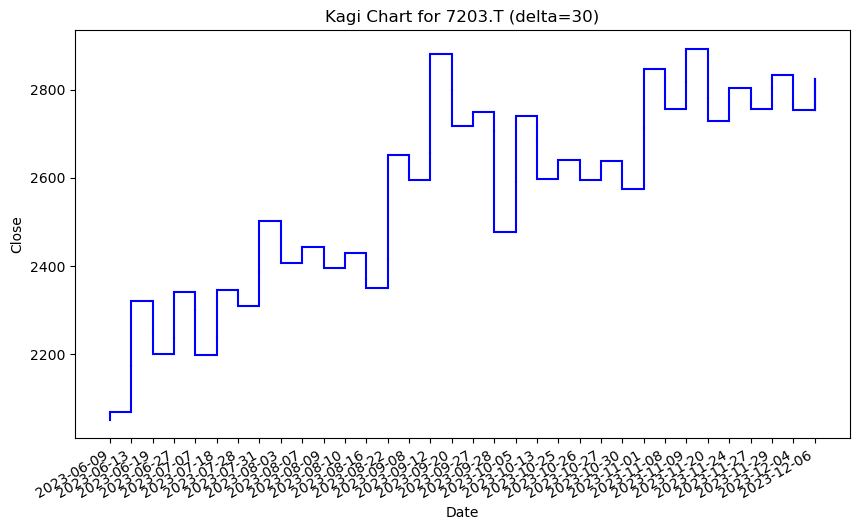

In [4]:
# 株価データの準備
df = stock_data.copy().reset_index()
delta = 30 # 反転基準価格差の設定
df_kagi = KagiChart(df,delta)
# 最終データ行の処理
df_kagi.loc[df_kagi.shape[0]-1,'Direc'] = 'Line'
print(df_kagi.tail(10))
Date = df_kagi['Date']
Close = df_kagi['Close']
extreme = df_kagi['Extreme']
direction = df_kagi['Direc']
# X軸変数として用いるインデックスの生成
indices = range(len(Date))
fig, ax = plt.subplots(figsize =(10,6))
# 軸目盛には日付を対応させる
plt.xticks(indices, [date.strftime('%Y-%m-%d') for date in Date])
fig.autofmt_xdate()
# 上又は下方向の垂直線を描画し、同じくその起点から左方向へ水平線を描画し、一つ前の時点で垂直線を付け足す
for i in range(1,len(Date)):
    if direction[i] == 'Line':
        ax.plot([indices[i], indices[i]], [extreme[i], Close[i]], color='b')
    if direction[i] == 'up':
        ax.plot([indices[i], indices[i]], [extreme[i], Close[i]], color='b')
        ax.plot([indices[i-1], indices[i-1]], [extreme[i], Close[i-1]], color='b')
        plt.hlines(extreme[i], xmin=indices[i-1], xmax=indices[i], color='b')
    else:
        ax.plot([indices[i], indices[i]], [extreme[i], Close[i]], color='b')
        ax.plot([indices[i-1], indices[i-1]], [extreme[i], Close[i-1]], color='b')
        plt.hlines(extreme[i], xmin=indices[i-1], xmax=indices[i],color='b')
# グラフタイトルと軸ラベルを設定する
ax.set_title('Kagi Chart for '+symbol+' (delta='+str(delta)+')')
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.show()